<a href="https://colab.research.google.com/github/Shuxiang-Y/new/blob/branch1/%E3%83%99%E3%82%A4%E3%82%BA%E6%9C%80%E9%81%A9%E5%8C%96%E3%81%AB%E3%82%88%E3%82%8B%E6%BA%B6%E5%AA%92%E3%81%94%E3%81%A8%E3%81%AE%E5%8F%8E%E7%8E%87%E3%81%AE%E4%BA%88%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
pip install rdkit

In [120]:
pip install pubchempy

In [121]:
pip install GPyOpt

In [122]:
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import Descriptors
import pubchempy as pcp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [123]:
import GPyOpt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.metrics import mean_squared_error

In [124]:
import numpy as np
import pandas as pd

In [125]:
pip install scikit-optimize

In [128]:
from pandas import Series,DataFrame

In [129]:
#データのインポート
df = pd.read_excel('solvent_yield_2.xlsx')
df.head()

,MW,surface tension,dipole moment,dielectric Constant,viscosity,logP,density
0,84.93,27.2,1.60,9.1,0.43,2.965,1.395
1,41.05,29.3,3.92,37.5,0.37,-0.430,0.787
2,92.14,28.4,0.40,2.4,0.59,2.700,0.846
3,168.04,16.1,2.05,16.7,1.65,1.660,1.456
4,100.04,21.1,2.46,26.7,1.76,-1.000,1.410


In [130]:
# 0: CH2Cl2, 1: MeCN, 2: MeNO2, 3: toluene, 4: HFIP, 5: TFE, 6: 2-propanol
X = df.to_numpy()
print(X)
print(X.shape)
y = np.array([41,9,5,92,72,5])
y.shape

[[ 84.93   27.2     1.6     9.1     0.43    2.965   1.395]
 [ 41.05   29.3     3.92   37.5     0.37   -0.43    0.787]
 [ 92.14   28.4     0.4     2.4     0.59    2.7     0.846]
 [168.04   16.1     2.05   16.7     1.65    1.66    1.456]
 [100.04   21.1     2.46   26.7     1.76   -1.      1.41 ]
 [ 60.1    21.2     1.66   19.9     2.07    0.3     0.785]]
(6, 7)


(6,)

In [131]:
def objective_function(params):
    alpha = params[0][0]
    kernel = Matern(length_scale=params[0][1:])
    regressor = GaussianProcessRegressor(kernel=kernel, alpha=alpha)
    regressor.fit(X, y)
    y_pred = regressor.predict(X)
    return mean_squared_error(y, y_pred)

In [132]:
# 各パラメータの探索範囲を定義
bounds = [{'name': 'alpha', 'type': 'continuous', 'domain': (1e-6, 1e2)}]
bounds += [{'name': f'length_scale_{i}', 'type': 'continuous', 'domain': (1e-6, 1e2)} for i in range(X.shape[1])]

In [152]:
# Bayesian Optimizationで最適なパラメータを探索
optimizer = GPyOpt.methods.BayesianOptimization(f=objective_function, domain=bounds, model_type='GP', acquisition_type='EI', batch_size=1, exact_feval = True)
optimizer.run_optimization(max_iter=31)

In [153]:
# 最適なパラメータでモデルを再構築
best_params = optimizer.x_opt
best_alpha = best_params[0]
best_kernel_params = best_params[1:]
best_kernel = Matern(length_scale=best_kernel_params)
best_regressor = GaussianProcessRegressor(kernel=best_kernel, alpha=best_alpha)
best_regressor.fit(X, y)

GaussianProcessRegressor(alpha=0.6056138881157963,
                         kernel=Matern(length_scale=[77.9, 81.3, 18.4, 11.3, 26.3, 33.8, 19.8], nu=1.5))

In [154]:
x_test = [[61.04,36.5,3.46,35.9,0.61,-0.35,1.132]]
y_test = best_regressor.predict(x_test)

In [155]:
y_test

array([24.5769201])

In [156]:
new_Y_pred = best_regressor.predict(X)

In [157]:
print("Predicted values for new data:")
for i, pred in enumerate(new_Y_pred):
    print(f"Data point {i + 1}: {pred}")

Predicted values for new data:
Data point 1: 41.14478090282131
Data point 2: 6.544026853314134
Data point 3: 7.281368550928421
Data point 4: 63.142973186458306
Data point 5: 62.028077160110996
Data point 6: 5.842563385764469


In [158]:
print(new_Y_pred)

[41.1447809   6.54402685  7.28136855 63.14297319 62.02807716  5.84256339]


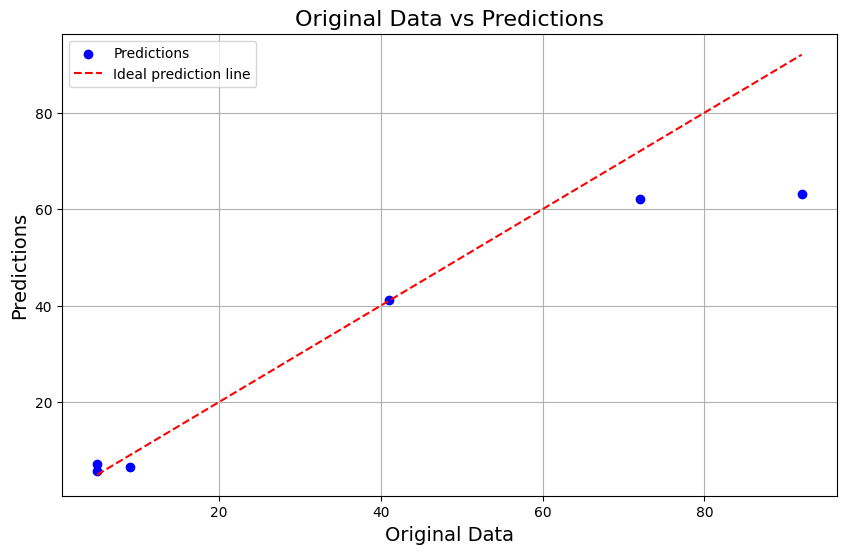

In [159]:
plt.figure(figsize=(10, 6))
plt.scatter(y, new_Y_pred, color='blue', label='Predictions')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', label='Ideal prediction line')
plt.xlabel('Original Data', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.title('Original Data vs Predictions', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

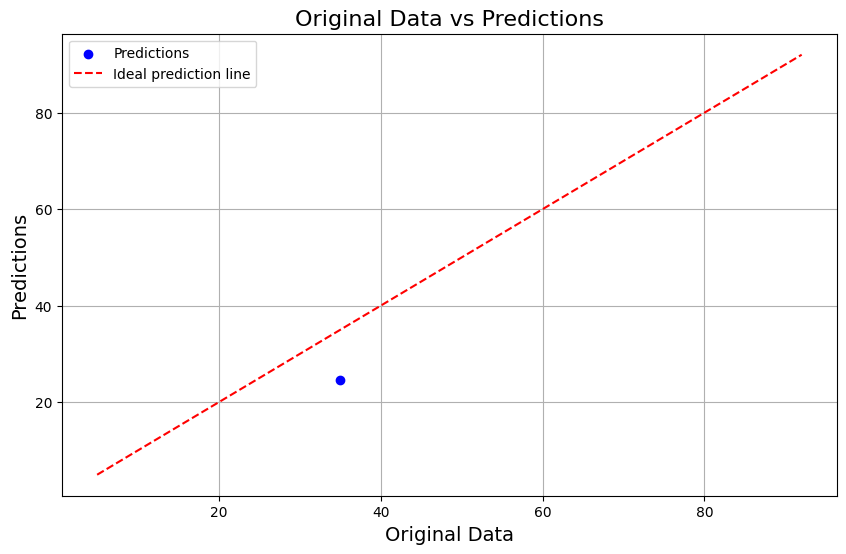

In [160]:
y_test_original = [35]
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_test, color='blue', label='Predictions')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', label='Ideal prediction line')
plt.xlabel('Original Data', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.title('Original Data vs Predictions', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()